#Transformer based Text Classfication

In this session we'll make use of pre-trained Transformer models for building various types of text classifiers, some of which are multi-lingual. In particular, the notebook demonstrates the training of BERT-based text classifiers for: 
- categorising news group messages 
- detecting sentiment in Twitter messages
- determining if a sentence paraphrases another.

The notebook makes use of: 
- for training Transformer models from HuggingFace: https://github.com/huggingface/transformers

Much of the notebook is based on: 
- this blog post: https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed
- this Google Colab notebook: https://colab.research.google.com/drive/1YxcceZxsNlvK35pRURgbwvkgejXwFxUt
- this notebook: https://github.com/amaiya/ktrain/blob/master/examples/text/MRPC-BERT.ipynb


## 6.1  Check GPU and install huggingface library

**NOTE**: To run this notebook, you will **need a GPU** (Graphics Processing Unit) card 
- the notebook has been tested on Google Colab and you are advised to run it there
- to use a GPU, you need to click on "Runtime" above, then "Change runtime type" and for "Hardware accelerator" choose the "GPU" option

Run the code below to check whether there is a gpu available:

In [ ]:
!pip3 install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.5 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
  raise SystemError('GPU device not found')

## 6.2  Load the 20 Newsgroups dataset

In the first example we'll build a multi-class classifier for newsgroup messages, as examples of longer text messages.

Training on all of the documents in the dataset will take too long (a few hours), so we'll use just 4 today. 
- If you want to try on the full dataset, just remove the 'categories' attribute from the commands below. 
- Be warned though, that training time will be MUCH longer if you include all of the data, so first try subset of the categories.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'rec.sport.baseball', 'sci.med', 'alt.atheism']
train = fetch_20newsgroups(subset='train', shuffle=True, categories=categories)
test = fetch_20newsgroups(subset='test', shuffle=True, categories=categories)

Print out some basic information about the dataset:

In [ ]:
print('# train instances: ', len(train.data))
print('# test instances:  ', len(test.data))
print('classes: ', train.target_names)

# train instances:  2255
# test instances:   1501
classes:  ['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med']


A class histogram shows that there is a relatively even distribution of messages across the categories:

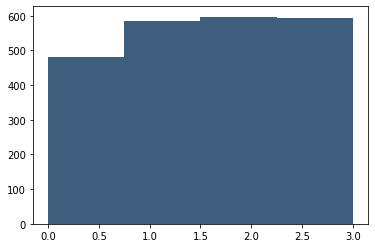

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train.target,bins=len(train.target_names),color="#3F5D7D");

## 6.3 Creating a model and preprocessing data

For the moment we will use the standard pretrained Multilingual BERT model. Note that this **model is big**! 
- it contains 110 million parameters
- it represents words (subword tokens to be precise) with embeddings of size 768 <-- compare this with the 50 dimensions we used with GloVe
- it contains 12 self-attention layers (each with 12 heads) stacked on top each other

In [ ]:
model_name = 'bert-base-multilingual-uncased'

There are many other pretrained models availalable here: https://huggingface.co/transformers/pretrained_models.html
- Give them a try and see which ones are faster and/or more stable to train!

Load the transformer setting the maximum text length to 500 and the classes to be the four newsgroup categories mentioned above.

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(categories))

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Move model to GPU

In [ ]:
bert = bert.to(device)

Now that we've downloaeded the base Multiligual BERT model, let's have a look at the architecture. 

In [ ]:
print(bert)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Check which of the parameters are trainable: 

In [ ]:
for param in bert.parameters():
    print(param.size(), param.requires_grad)

torch.Size([105879, 768]) True
torch.Size([512, 768]) True
torch.Size([2, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([3072, 768]) True
torch.Size([3072]) True
torch.Size([768, 3072]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([3072, 768]) True
torch.Size([3072]) True
torch.Size([768, 3072]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768,

Load the tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Now we can preprocess the training (and test) data using the transformer's data set API

First create a list of dictionaries with all the samples in the train and test data sets

In [ ]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(train.data, train.target)]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(test.data, test.target)]

Convert the data sets into the Huggingface data set API format

In [ ]:
train_data = Dataset.from_list(train_data)
test_data = Dataset.from_list(test_data)

Create a container with all the splits of the data set

In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = test_data
data['test'] = test_data

Finally use the tokenizer to convert the input strings into sequences of tokens (more on this later)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_data = data.map(tokenize_function, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Let's have a quick look at what the tokenised data looks like: 
- First print out the text of the first document:

In [ ]:
print(train.data[0])

From: cab@col.hp.com (Chris Best)
Subject: Re: Is MSG sensitivity superstition?
Organization: your service
Lines: 20
NNTP-Posting-Host: hpctdkz.col.hp.com


Jason Chen writes:
> Now here is a new one: vomiting. My guess is that MSG becomes the number one
> suspect of any problem. In this case. it might be just food poisoning. But
> if you heard things about MSG, you may think it must be it.

----------

Yeah, it might, if you only read the part you quoted.  You somehow left 
out the part about "we all ate the same thing."  Changes things a bit, eh?

You complain that people blame MSG automatically, since it's an unknown and
therefore must be the cause.  It is equally (if not more) unreasonable to
defend it, automatically assuming that it CAN'T be the culprit.

Pepper makes me sneeze.  If it doesn't affect you the same way, fine.
Just don't tell me I'm wrong for saying so.

These people aren't condemning Chinese food, Mr. Chen - just one of its 
(optional) ingredients.  Try not to take 

Now print out the result of preprocessing the first document: 

In [ ]:
print(tokenizer(train.data[0]).input_ids)

[101, 10195, 131, 70438, 137, 12308, 119, 20931, 119, 10241, 113, 13446, 11146, 114, 19513, 131, 11449, 131, 10127, 16777, 10251, 20242, 14119, 52902, 12278, 12054, 11101, 136, 14935, 131, 12787, 11416, 17294, 131, 10200, 37580, 84723, 118, 42191, 10422, 118, 17624, 131, 20931, 15106, 10163, 10167, 10311, 119, 12308, 119, 20931, 119, 10241, 17110, 20728, 47332, 131, 135, 11628, 14048, 10127, 143, 10246, 10399, 131, 11106, 69431, 119, 11153, 41567, 22523, 10127, 10203, 16777, 10251, 23259, 10103, 11395, 10399, 135, 75695, 10108, 11318, 15640, 119, 10104, 10372, 12700, 119, 10197, 20025, 10346, 12125, 15225, 55340, 10285, 119, 10502, 135, 11526, 10855, 27134, 17994, 10935, 16777, 10251, 117, 10855, 10431, 21506, 10197, 14650, 10346, 10197, 119, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 82600, 117, 10197, 20025, 117, 11526, 10855, 10902, 18593, 10103, 10649, 10855, 62259, 119, 10855, 10970, 38644, 12174, 10871, 10103, 10649, 10935, 107, 11312, 10367, 12811, 10103, 11714, 21973, 11

Each integer above is the index of a token from the vocabulary of the BERT model. 
- How big is the vocabulary?

In [ ]:
print("vocabulary size: ", len(tokenizer.vocab))

vocabulary size:  105879


This vocabulary is relatively small compared to many word embeddings discussed in the lecture, which often reach over 1 million distinct words. 
- The vocab size is kept relatively small through the use of sub-word tokens that are found using a byte-pair encoding scheme.
- We can take a single string and run it through the tokenizer to see the tokens produced as follows:

In [ ]:
example_text = "I always wondered what those Transformer models were doing to my text. Here is a OutOfVocabWord."
encoded_text = tokenizer(example_text).input_ids
vocab_terms = list(tokenizer.vocab.keys())
vocab_index = list(tokenizer.vocab.values())
print("input text: "+example_text)
print("tokenized:  ", [vocab_terms[vocab_index.index(i)] for i in encoded_text])

input text: I always wondered what those Transformer models were doing to my text. Here is a OutOfVocabWord.
tokenized:   ['[CLS]', 'i', 'always', 'wonder', '##ed', 'what', 'those', 'transforme', '##r', 'models', 'were', 'doing', 'to', 'my', 'text', '.', 'here', 'is', 'a', 'out', '##of', '##vo', '##ca', '##b', '##word', '.', '[SEP]']


Note that:
- a '[CLS]' token has been added to the start of the tokenized text and a '[SEP]' token to the end.
- BERT works as a masked autoencoder, meaning that it is trained to produce the same terms as output that are presented in input, including those that were masked out.
- the '[CLS]' token is simply a special mask for the unknown class label that needs to be produced at the output. 
- the Byte-Pair Encoding has removed the suffixes from certain words (e.g. 'wondered' lost the 'ed'), but not all of them ('models' kept the 's'). 

## 6.4  Training the model

Now we're ready to start training the model. 

Prepare training arguments (including a name for the trainer)

In [ ]:
training_args = TrainingArguments(
    "cool_trainer_name", 
    per_device_train_batch_size=16
)

Disable weights in model encoder

In [ ]:
# for param in bert.bert.parameters():
#     param.requires_grad = False

Build the traininer using the Huggingface trainer API

In [ ]:
trainer = Trainer(
    model=bert, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation']
)

Finally, run the training process (we train for three epochs)



In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2255
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 423
  Number of trainable parameters = 167359492


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=423, training_loss=0.15666667676704712, metrics={'train_runtime': 637.254, 'train_samples_per_second': 10.616, 'train_steps_per_second': 0.664, 'total_flos': 1779978252349440.0, 'train_loss': 0.15666667676704712, 'epoch': 3.0})

Sorry Mark, no learning rate plot :(

## 6.5  Evaluating the model

Now that the model has finished training, let's evaluate in on the test data.

First we can run the evaluation process included with the trainer

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1501
  Batch size = 8


KeyboardInterrupt: ignored

Then we can get the predictions on the test set...

In [ ]:
preds = trainer.predict(tokenized_data['test'])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1501
  Batch size = 8


Convert predicted logits to classes using the $\mathrm{argmax}$ operator

In [ ]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred

array([0, 1, 1, ..., 1, 1, 3])

Get target label names

In [ ]:
label_names = test.target_names

... and use them to preprare a classification report using Scikit-Learn API

In [ ]:
print(classification_report(test.target, y_pred, target_names=label_names))

                    precision    recall  f1-score   support

       alt.atheism       0.92      0.96      0.94       319
     comp.graphics       0.96      0.98      0.97       389
rec.sport.baseball       0.99      0.97      0.98       397
           sci.med       0.98      0.94      0.96       396

          accuracy                           0.96      1501
         macro avg       0.96      0.96      0.96      1501
      weighted avg       0.96      0.96      0.96      1501



... or compute a confusion matrix using the Scikit-Learn API

In [ ]:
print(confusion_matrix(test.target, y_pred))

[[307   5   1   6]
 [  8 381   0   0]
 [  5   4 386   2]
 [ 14   8   1 373]]


We can have a look at the test examples on which the model made the worst predictions:

Compute loss

In [ ]:
loss = torch.nn.functional.cross_entropy(torch.tensor(preds.predictions), torch.tensor(preds.label_ids), reduction='none')
loss

tensor([1.0286e-03, 2.1525e-03, 1.4707e-03,  ..., 5.3434e+00, 1.3284e-03,
        1.1755e-03])

Identify the index of the element with the highest loss

In [ ]:
index_of_instance = torch.argmax(loss).item()
index_of_instance

894

Loss of the corresponding sample

In [ ]:
loss[index_of_instance].item()

7.897991180419922

Predicted class and target class

In [ ]:
print(f'Target class:    {label_names[test.target[index_of_instance]]}')
print(f'Predicted class: {label_names[y_pred[index_of_instance]]}')

Target class:    rec.sport.baseball
Predicted class: comp.graphics


Print out the post with the top loss (by changing INDEX_OF_INSTANCE below) to try to find out why it is confusing the classfier. 

In [ ]:
print(test.data[index_of_instance])

From: snichols@adobe.com (Sherri Nichols)
Subject: Re: Bonilla
Organization: Adobe Systems Incorporated
Lines: 9

In article <1993Apr20.034558.28920@midway.uchicago.edu> thf2@midway.uchicago.edu writes:
>>Gary Varsho
>
>Halfway there, and unlikely to make it 3/4 of the way there.

Wait a minute; I could swear that Varsho is white.

Sherri Nichols
snichols@adobe.com



## 6.6 Making predictions on new data

We can run the trained classification model on new examples. 

Define a simple function to make a prediction

In [ ]:
@torch.no_grad()
def predict(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)

    lbl = label_names[torch.argmax(outputs.logits).item()]

    return lbl

Define  simple function to predict the classes probabilities

In [ ]:
@torch.no_grad()
def predict_proba(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)

    proba = torch.softmax(outputs.logits, dim=1).cpu().squeeze().numpy()

    return dict(zip(label_names, proba))

In [ ]:
@torch.no_grad()
def predict_proba_values(text):
    input_encodings = tokenizer(text, return_tensors='pt', padding=True).to(device)
    outputs = bert(**input_encodings)

    proba = torch.softmax(outputs.logits, dim=1).cpu().squeeze().numpy()

    return proba

We can now try the trained model on new samples

In [ ]:
sample_text = 'Both of the home runs hit by Fernando Tatís in the third inning for the St. Louis Cardinals on April 23, 1999, were grand slams.'
predict(sample_text)

'rec.sport.baseball'

We can see the probabilities assigned by the model to each of the classes as follows:

In [ ]:
predict_proba(sample_text).values()

dict_values([0.0002826381, 0.0003475913, 0.9987453, 0.0006244561])

Where the classes are:

In [ ]:
predict_proba(sample_text).keys()

dict_keys(['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med'])

OK, so the model appears to work well on English text.

## 6.7 Multi-lingual examples

Let's try on a phrase in another language (Italian). 
- Note that the news group data we used to train the model is in English only, so the model has never seen any examples of news group messages in Italian.

In [ ]:
italian_text = 'I tasti su e giù sul mio portatile non funzionano più, quindi non posso più usarlo per giocare ;-('
predict(italian_text)

'comp.graphics'

In [ ]:
predict_proba(italian_text)

NameError: ignored

Did it get the prediction right? 
- Note that while the characer set for Italian and English is almost the same, there weren't any words (except perhaps for "non") in the above message that would have occurred in the training data. 

Let's try a message in a different character set: 
- Translate the text into Chinese using Google Translate: https://translate.google.com/
- Then copy the text below and rerun the prediction. 
- Does it still work? 



In [ ]:
chinese_text = '笔记本电脑上的向上和向下键不再起作用，因此我无法再使用它来播放;-(' #'INSERT CHINESE TEXT HERE'
predict(chinese_text)

'comp.graphics'

In [ ]:
russian_text = "Клавиши «вверх» и «вниз» на моем ноутбуке больше не работают, поэтому я больше не могу использовать их для игры ;-("
predict(russian_text)

'comp.graphics'

## 6.8  Explaining the predictions

Let's try another piece of text, this time in English, but talking about a politician who wasn't a politician (but rather a celebrity) at the time in which the 20 News Groups dataset was created:

In [ ]:
sample_text = 'Donald Trump is the greatest living ex-president in the history of living ex-presidents. He\'s also a bad golfer.'
predict(sample_text)

'rec.sport.baseball'

Let's invoke the `explain` method to see which words contribute most to the classification.

We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [ ]:
# !pip3 install -q h5py typing-extensions wheel 
# !pip install --upgrade jinja2==3.0.2
! pip uninstall flask
!pip3 install -q eli5

Found existing installation: Flask 1.1.4
Uninstalling Flask-1.1.4:
  Would remove:
    /usr/local/bin/flask
    /usr/local/lib/python3.8/dist-packages/Flask-1.1.4.dist-info/*
    /usr/local/lib/python3.8/dist-packages/flask/*
Proceed (Y/n)? y
  Successfully uninstalled Flask-1.1.4


In [ ]:
import eli5
from eli5.lime import TextExplainer

Run the explainer (based on LIME) to see which words in the sentence are most important for the prediction:

In [ ]:
# See https://amaiya.github.io/ktrain/text/predictor.html
# See https://eli5.readthedocs.io/en/latest/autodocs/lime.html
def explain(text, truncate_len=512, all_targets=False, n_samples=2500):
    prediction = [predict(text)] if not all_targets else None
    text = " ".join(text.split()[:truncate_len])
    te = TextExplainer(random_state=42, n_samples=n_samples)
    _ = te.fit(text, predict_proba_values)
    return te.show_prediction(
        target_names=label_names, targets=prediction
    )

In [ ]:
explain(sample_text)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The words in the darkest shade of green contribute most to the classification.
- Do they agree with what you would have expected for this example?

## 6.9 Inspecting the Model

Let's have a look at the architecture of the model that we have used:

In [ ]:
print(bert)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Compute the total number of parameters

In [ ]:
n_params = sum(param.numel() for param in bert.parameters())
n_params

167359492

The model contains over 100 million parameters consists of:
- BERT (which contains alost all the parameters), 
- a drop-out layer (that is inserted to prevent overfitting), and 
- a dense (feedforward) layer to map the BERT embedding of size 768 to the 2 output neurons (representing the positive and negative classes).

Let's print out information on the configuration of BERT.

In [ ]:
bert.bert.config

BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.26.0",
  "type_voca

## 6.10 Saving and loading a fine-tuned model

We can save predictor for later use

In [ ]:
bert.save_pretrained('/tmp/my_predictor')

Configuration saved in /tmp/my_predictor/config.json
Model weights saved in /tmp/my_predictor/pytorch_model.bin


Reload the predictor and use it to predict the class of a new piece of text:

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained('/tmp/my_predictor').to(device)
predict('My computer monitor is really blurry.')

loading configuration file /tmp/my_predictor/config.json
Model config BertConfig {
  "_name_or_path": "/tmp/my_predictor",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_

'comp.graphics'

## 6.11 Classifying the sentiment of Twitter messages

We'll now train a different model to detect sentiment on Twitter data as we did for the previous tutorials:

In [ ]:
import nltk
nltk.download('twitter_samples')

from nltk.corpus import twitter_samples
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

import re 
emoticon_regex = '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)'
positive_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in positive_tweets]
negative_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in negative_tweets]

tweets_x = positive_tweets_noemoticons + negative_tweets_noemoticons
tweets_y = [1]*len(positive_tweets) + [0]*len(negative_tweets)

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


Use scikit-learn to split the data into training, validation and test sets:


In [ ]:
from sklearn.model_selection import train_test_split
temp_x, test_x, temp_y, test_y = train_test_split(tweets_x, tweets_y, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

In [ ]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(train_x, train_y)]
valid_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(valid_x, valid_y)]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(test_x, test_y)]

In [ ]:
train_data = Dataset.from_list(train_data)
test_data = Dataset.from_list(test_data)
valid_data = Dataset.from_list(valid_data)
data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data
data['test'] = test_data

Now **repeat** all the steps from before for the twitter data: 

1.   Load the model (this time we'll try DistilBERT, which is a smaller transformer model)

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when in

2. Process the training/test data

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_data = data.map(tokenize_function, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

3. Create a model and learner

In [ ]:
training_args = TrainingArguments(
    'sentimental_analysing',
    per_device_train_batch_size=1,
    num_train_epochs=3
)
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation']
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


4.   Train the model (We'll run for one epoch to make it faster, but it would be better to run for 4 or more)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6400
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 19200
  Number of trainable parameters = 66955010


Step,Training Loss
500,1.020200
1000,1.138700
1500,1.045900
2000,1.017800
2500,0.945000
3000,0.965900
3500,0.983200
4000,0.920600
4500,1.015900
5000,1.087200


Saving model checkpoint to sentimental_analysing/checkpoint-500
Configuration saved in sentimental_analysing/checkpoint-500/config.json
Model weights saved in sentimental_analysing/checkpoint-500/pytorch_model.bin
Saving model checkpoint to sentimental_analysing/checkpoint-1000
Configuration saved in sentimental_analysing/checkpoint-1000/config.json
Model weights saved in sentimental_analysing/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to sentimental_analysing/checkpoint-1500
Configuration saved in sentimental_analysing/checkpoint-1500/config.json
Model weights saved in sentimental_analysing/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to sentimental_analysing/checkpoint-2000
Configuration saved in sentimental_analysing/checkpoint-2000/config.json
Model weights saved in sentimental_analysing/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to sentimental_analysing/checkpoint-2500
Configuration saved in sentimental_analysing/checkpoint-2500/config.js

Step,Training Loss
500,1.020200
1000,1.138700
1500,1.045900
2000,1.017800
2500,0.945000
3000,0.965900
3500,0.983200
4000,0.920600
4500,1.015900
5000,1.087200


Saving model checkpoint to sentimental_analysing/checkpoint-15000
Configuration saved in sentimental_analysing/checkpoint-15000/config.json
Model weights saved in sentimental_analysing/checkpoint-15000/pytorch_model.bin
Saving model checkpoint to sentimental_analysing/checkpoint-15500
Configuration saved in sentimental_analysing/checkpoint-15500/config.json
Model weights saved in sentimental_analysing/checkpoint-15500/pytorch_model.bin
Saving model checkpoint to sentimental_analysing/checkpoint-16000
Configuration saved in sentimental_analysing/checkpoint-16000/config.json
Model weights saved in sentimental_analysing/checkpoint-16000/pytorch_model.bin
Saving model checkpoint to sentimental_analysing/checkpoint-16500
Configuration saved in sentimental_analysing/checkpoint-16500/config.json
Model weights saved in sentimental_analysing/checkpoint-16500/pytorch_model.bin
Saving model checkpoint to sentimental_analysing/checkpoint-17000
Configuration saved in sentimental_analysing/checkpoin

TrainOutput(global_step=19200, training_loss=0.7251875372727712, metrics={'train_runtime': 964.9055, 'train_samples_per_second': 19.898, 'train_steps_per_second': 19.898, 'total_flos': 355954388810400.0, 'train_loss': 0.7251875372727712, 'epoch': 3.0})

5.   Evaluate the model

In [ ]:
preds = trainer.predict(tokenized_data['test'])
test_y = preds.label_ids

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 8


Convert predicted logits to classes using the $\mathrm{argmax}$ operator

In [ ]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred

array([0, 1, 1, ..., 0, 1, 0])

Get target label names

In [ ]:
label_names = ['negative', 'positive']

... and use them to preprare a classification report using Scikit-Learn API

In [ ]:
print(classification_report(test_y, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.82      0.84      0.83       988
    positive       0.84      0.82      0.83      1012

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



... or compute a confusion matrix using the Scikit-Learn API

In [ ]:
print(confusion_matrix(test_y, y_pred))

[[832 156]
 [183 829]]


6.   Make some predictions with it

In [ ]:
@torch.no_grad()
def predict(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)

    lbl = label_names[torch.argmax(outputs.logits).item()]

    return lbl

In [ ]:
predict('Had a lot of fun today!')

'positive'

Did it work?

Let's print out some information about the architecture of this model:

In [ ]:
print(bert)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
n_params = sum(param.numel() for param in bert.parameters())
print(n_params)

66955010


We see that the distilbert model has fewer parameters than the BERT model we used previously. It's interesting to see the pre-classifier layer in this model that maps the output embeddings from the transformer into a second embedding space (of the same size) that is then used as features for the final classification layer.
